In [6]:
# Import the functions used in this project
from private_pkg.functions import *

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
submission = pd.read_csv("../asset/sample_submission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("submission  data : ", submission.shape)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
def fitNaiveBayesModel(X, y):
    return MultinomialNB().fit(X, y)
import xgboost
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_submission = submission.copy()

Train data :  (647054, 7)
Test  data :  (653646, 6)
submission  data :  (95674, 39)


In [8]:
import pickle as pkl
slack_url = pkl.load(open("send_url.pickle", "rb"))

In [3]:
df_X_train = pd.read_csv("df_we_wanted_201807251743.csv")

In [7]:
cols = getColsToMakeFeatureMatrix(df_test, df_train)

In [8]:
X = df_X_train[cols]
y = df_X_train["TripType"]

In [14]:
rbfsvc = SVC(kernel="rbf", probability=True).fit(X, y)

In [15]:
y_pred = rbfsvc.predict(X)

In [16]:
sendSlackDm(slack_url, "rbf svm train predict 완료")

In [17]:
getAccuracy(y, y_pred, len(X))

##### Accuracy : 0.6927

In [18]:
y_pred_proba_rbfsvc = rbfsvc.predict_proba(X)

In [19]:
sendSlackDm(slack_url, "rbf svm train predict 완료")

In [20]:
rbfsvc_submit_df = makeSubmissionDf(submission, y_pred_proba_rbfsvc)

In [21]:
saveDataFrameToCsv(rbfsvc_submit_df, "rbfsvc_submit_df")

Feature ranking:
1. feature 11 (0.062614)
2. feature 4 (0.054330)
3. feature 6 (0.051623)
4. feature 27 (0.047535)
5. feature 5 (0.041841)
6. feature 49 (0.040203)
7. feature 56 (0.037924)
8. feature 39 (0.036946)
9. feature 26 (0.033428)
10. feature 2 (0.028952)
11. feature 21 (0.028232)
12. feature 8 (0.025364)
13. feature 54 (0.024466)
14. feature 0 (0.023671)
15. feature 13 (0.022888)
16. feature 23 (0.022194)
17. feature 65 (0.021699)
18. feature 20 (0.020902)
19. feature 19 (0.020682)
20. feature 10 (0.020182)
21. feature 29 (0.019898)
22. feature 58 (0.018682)
23. feature 33 (0.018263)
24. feature 40 (0.017429)
25. feature 42 (0.016990)
26. feature 22 (0.015378)
27. feature 25 (0.014340)
28. feature 63 (0.013634)
29. feature 48 (0.013110)
30. feature 61 (0.012672)
31. feature 17 (0.011741)
32. feature 24 (0.010883)
33. feature 32 (0.010383)
34. feature 44 (0.009983)
35. feature 51 (0.009505)
36. feature 12 (0.009409)
37. feature 31 (0.008868)
38. feature 36 (0.008704)
39. featur

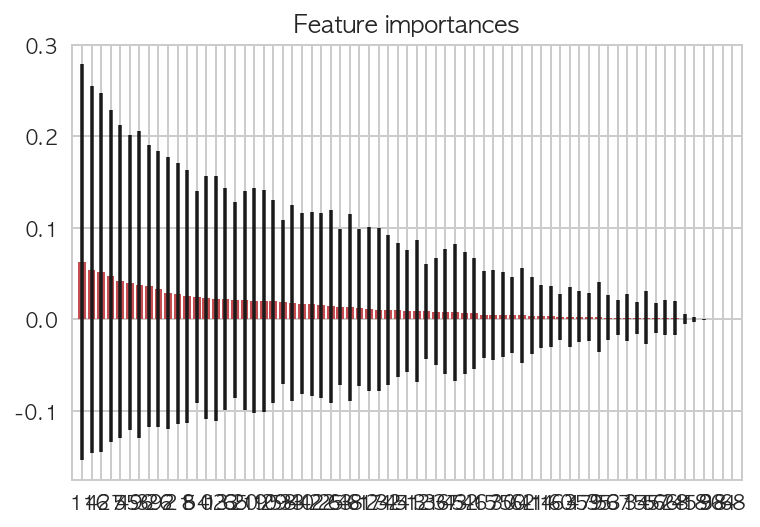

In [10]:
sendSlackDm(slack_url, "rbf svm train predict 완료")
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250, random_state=0, max_depth = 2)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

sendSlackDm(slack_url, "랜덤포레스트 250 완료")

In [22]:
y_pred_forest = forest.predict(X)

In [23]:
getAccuracy(y, y_pred_forest, len(X))

##### Accuracy : 0.1445

In [51]:
param_range = np.arange(0, 170, 10)

In [52]:
len(param_range[1:])

16

In [65]:
max_depth_range = np.arange(30, 41)

In [54]:
len(max_depth_range)

16

In [78]:
max_depth_range = np.arange(1, 21)

In [70]:
forest_40 = ExtraTreesClassifier(n_estimators=50, random_state=0, max_depth=40)

In [71]:
forest_40.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=40, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [72]:
y_pred = forest_40.predict(X)

In [73]:
getAccuracy(y, y_pred, len(X))

##### Accuracy : 0.7832

In [74]:
y_pred_proba_forest = forest_40.predict_proba(X)

In [75]:
submit_forest = makeSubmissionDf(submission, y_pred_proba_forest)

In [76]:
saveDataFrameToCsv(submit_forest, "submit_random_forest_40")

In [66]:
from sklearn.ensemble import ExtraTreesClassifier
forest_gs = ExtraTreesClassifier(n_estimators=50, random_state=0)

param_grid = [
    {'max_depth': max_depth_range}
]

gs = GridSearchCV(estimator=forest_gs, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
%time gs = gs.fit(X, y)
sendSlackDm(slack_url, "랜덤포레스트 250 완료")

CPU times: user 13 s, sys: 391 ms, total: 13.4 s
Wall time: 1min 59s


In [64]:
results_1_30

In [67]:
results_30_40 = gs.cv_results_["mean_test_score"]

In [62]:
print(gs.best_score_)
print(gs.best_params_)

0.5114451157054163
{'max_depth': 30}


In [68]:
print(gs.best_score_)
print(gs.best_params_)

0.6144407048937015
{'max_depth': 40}


In [69]:
results_30_40

array([0.51144512, 0.51644125, 0.52020403, 0.52469846, 0.52880615,
       0.53313335, 0.54049167, 0.55731965, 0.56038213, 0.5887702 ,
       0.6144407 ])

In [92]:
model_xgb_n_jobs = xgboost.XGBClassifier(n_estimators=50, n_jobs=-1)

In [96]:
max_depth_range = np.arange(10, 22, 2)

In [97]:
max_depth_range

array([10, 12, 14, 16, 18, 20])

In [93]:
param_grid = [
    {'max_depth': max_depth_range}
]

gs = GridSearchCV(estimator=model_xgb_n_jobs, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
%time gs = gs.fit(X, y)

CPU times: user 12min 10s, sys: 992 ms, total: 12min 11s
Wall time: 49min 37s


In [94]:
sendSlackDm(slack_url, "xgboost grid search cv 완료")

In [95]:
print(gs.best_score_)
print(gs.best_params_)

0.6323661600852897
{'max_depth': 8}


In [98]:
param_grid = [
    {'max_depth': max_depth_range}
]

gs = GridSearchCV(estimator=model_xgb_n_jobs, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
%time gs = gs.fit(X, y)
sendSlackDm(slack_url, "xgboost grid search cv 완료")

CPU times: user 24min 31s, sys: 2.46 s, total: 24min 33s
Wall time: 2h 34min 19s


In [99]:
print(gs.best_score_)
print(gs.best_params_)

0.6539812279198111
{'max_depth': 20}


In [100]:
y_pred_xgb = gs.predict(X)

In [101]:
getAccuracy(y, y_pred_xgb, len(X))

##### Accuracy : 0.8173

In [102]:
y_pred_xgb_proba = gs.predict_proba(X)

In [104]:
submit_xgb_proba = makeSubmissionDf(submission, y_pred_xgb_proba)

In [105]:
saveDataFrameToCsv(submit_xgb_proba, "submit_xgb_proba_grid_search_best_score")

In [2]:
# Save Model Using joblib
from sklearn.externals import joblib

# save the model to disk
filename = 'finalized_gs_xgb_model.pkl'
joblib.dump(gs, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.best_params_
print(result)

{'max_depth': 20}


In [13]:
loaded_model.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': array([10, 12, 14, 16, 18, 20])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)>

In [10]:
y_pred_xgb = loaded_model.predict(X)

In [12]:
getAccuracy(y, y_pred_xgb, len(X))

##### Accuracy : 0.8173